In [2]:
import pandas as pd
import pyterrier as pt
import os
import numpy as np

In [3]:
if not pt.started():
    pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



Task 1.1: data cleaning process

In [9]:
policy = pd.read_csv('policy.csv', encoding='latin-1')


In [10]:
policy['docno'] = np.nan
policy['docno'] = policy.reset_index()
policy['docno'] = policy['docno'] + 1
policy['docno'] = policy['docno'].astype(str)
policy['text']  = policy['policy'].apply(str)


In [11]:
policy = policy.drop(['policy'], axis = 1)
policy

,docno,text
0,1,Afghanistan Data.quality.review.conducted.to.d...
1,2,Bangladesh Data.quality.review.conducted.to.de...
2,3,Bhutan Data.quality.review.conducted.to.determ...
3,4,Brunei Darussalam Data.quality.review.conducte...
4,5,Cambodia Data.quality.review.conducted.to.dete...
...,...,...
16728,16729,Solomon Islands Where.viral.load.testing.is.av...
16729,16730,Tonga Where.viral.load.testing.is.available.Na...
16730,16731,Tuvalu Where.viral.load.testing.is.available.N...
16731,16732,Vanuatu Where.viral.load.testing.is.available....


In [12]:
# new = policy["text"].str.split(" ", n = 2, expand = True)

# policy['country'] = new[0]
# policy['policy'] = new[1]
# count = 0
# for val in (policy.groupby('policy').count()['docno'] == 1):
#     if(val == True):
#         count += 1     
# policy['country'].unique()


Task 1.2: create policy index

In [13]:
index_dir = './policy_index'
indexer = pt.DFIndexer(index_dir, overwrite=True)
index_ref = indexer.index(policy["text"], policy["docno"])
index_ref.toString()

'./policy_index/data.properties'

In [14]:
index = pt.IndexFactory.of(index_ref)

In [15]:
pl2 = pt.BatchRetrieve(index, wmodel="PL2")

task 1.3: create annotation 

In [ ]:
### that part is for creating annotation
query = "20. policy on Community engagement in PMTCT in Tonga"
resultcsv = pd.DataFrame()
top100doc = pl2.search(query)[0:100]
#### pl2 / tf-idf pick ranodm one
val = top100doc.docno.values

resultcsv = policy[policy['docno'].apply(lambda x: x in val)]
resultcsv['rank'] = np.nan
resultcsv['query'] = query

resultcsv.to_csv('query13.csv')

Task 2.2: read annotation part and create our own query and relevance dataset

In [4]:
from sklearn.model_selection import train_test_split

annotation = pd.read_csv('annotation.csv').drop(['Unnamed: 0'], axis = 1)
#annotation = annotation.sort_values(by = 'qid')
dictForDocSort = {}
for docIndex in range(len(annotation.docno.unique())):
    dictForDocSort[annotation.docno.unique()[docIndex]] = docIndex
annotation.docno = annotation.docno.apply(lambda x: dictForDocSort[x])
annotation['qid'] = annotation['qid'].astype(str)
annotation['docno'] = annotation['docno'].astype(str)

queryDF = annotation[['qid','docno','rank']]
queryDF = queryDF.sort_values(by='qid')
queryDF = queryDF.reset_index()
queryDF.loc[:,'qid'] = queryDF['qid'].astype(str)
queryDF.loc[:,'label'] = queryDF['rank'].astype(int)
queryDF.loc[:,'docno'] = queryDF['docno'].astype(str)
queryDF = queryDF.drop(['rank','index'], axis = 1)

relevanceDF = annotation[['qid','query']]
relevanceUnique = pd.DataFrame()
relevanceUnique['qid'] = relevanceDF['qid'].unique()
relevanceUnique['query'] = relevanceDF['query'].unique()

relevanceUnique = relevanceUnique.sort_values(by='qid')
relevanceUnique.loc[:,'qid'] = relevanceUnique['qid'].astype(str)
relevanceUnique.loc[:,'query'] = relevanceUnique['query'].astype(str)
relevanceUnique = relevanceUnique.reset_index()
relevanceUnique = relevanceUnique.drop(['index'], axis = 1)
#queryDF.head() ## should I rank by qid?
relevanceUnique.head()

#### reorder my query and relevance into correct way
query = relevanceUnique.copy()
relevance = queryDF.copy()

Task 2.3: create annotation index

In [5]:
annotationIndex = annotation[['docno', 'text']]
annotationIndex.loc[:,'docno'] = annotationIndex['docno'].astype(int)
annotationIndex = annotationIndex.sort_values(by = 'docno')
annotationIndex.loc[:,'docno'] = annotationIndex['docno'].astype(str)
annotationIndex = annotationIndex.reset_index()
annotationIndex = annotationIndex.drop(['index'], axis = 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [6]:
annotationIndex = annotationIndex.drop_duplicates()

In [7]:
annotationIndex

,docno,text
0,0,Afghanistan HIV.testing.recommended.in.nationa...
5,1,Bangladesh HIV.testing.recommended.in.national...
10,2,Nepal HIV.testing.recommended.in.national.guid...
15,3,Afghanistan HIV.testing.recommended.in.nationa...
20,4,Bangladesh HIV.testing.recommended.in.national...
...,...,...
5995,3932,Nauru Services.accessible.to.people.affected.b...
5996,3933,Nauru Services.accessible.to.people.affected.b...
5997,3934,Nauru Services.accessible.to.people.affected.b...
5998,3935,Nauru Sentinel.surveillance.conducted..People....


In [8]:
index_dir = './annotation_index'
indexer = pt.DFIndexer(index_dir, overwrite=True)
index_ref = indexer.index(annotationIndex["text"], annotationIndex["docno"])
index_ref.toString()
index = pt.IndexFactory.of(index_ref)

Task 2.4: create query-doc pair dataset for future assign cos-sim score

In [202]:
annotationQidDocPair = annotation.copy()
annotationQidDocPair['docno'] = annotationQidDocPair['docno'].astype(int)
annotationQidDocPair['qid'] = annotationQidDocPair['qid'].astype(int)
documents = annotationQidDocPair.docno.unique()
docText = {}
for doc in documents:
    docText[doc] = annotationQidDocPair['text'][annotationQidDocPair.docno == doc].values[0]
queries = annotationQidDocPair.qid.unique()
qidQuery = {}
for que in queries:
    qidQuery[que] = annotationQidDocPair['query'][annotationQidDocPair.qid == que].values[0]

In [ ]:
queryDocPair = {}
for index1 in range(len(annotationQidDocPair.qid)):
    if (annotationQidDocPair.qid[index1] not in queryDocPair.keys()):
        queryDocPair[annotationQidDocPair.qid[index1]] = []
    queryDocPair[annotationQidDocPair.qid[index1]].append(annotationQidDocPair.docno[index1])
queryAddPair = pd.DataFrame()
for key, values in queryDocPair.items():
    newDoc = np.setdiff1d(documents, values)
    for val in newDoc:
        queryAddPair = queryAddPair.append(
            {'docno': val,'text':docText[val],'rank':0,'query': qidQuery[key],'qid':key }, 
            ignore_index=True)


In [164]:
queryAddPair1 = queryAddPair[['docno','text','rank','query','qid']]
queryAddPair1['docno'] = queryAddPair1['docno'].astype(int)
queryAddPair1['qid'] = queryAddPair1['qid'].astype(int)
queryAddPair1['rank'] = queryAddPair1['rank'].astype(int)
qidDocPair = pd.concat([annotationQidDocPair, queryAddPair1], axis = 0)
qidDocPair = qidDocPair.reset_index()
qidDocPair = qidDocPair.drop(['index'],axis = 1)
#qidDocPair.to_csv('qidDocPair.csv')
qidDocPair = qidDocPair.sort_values(by = ['qid','docno'])
qidDocPair['docno'] = qidDocPair['docno'].astype(str)
qidDocPair['qid'] = qidDocPair['qid'].astype(str)
qidDocPair
qidDocPair.to_csv("qidDocPair.csv")

Task 2.5: create our baseline(bm25, randomEstimate)

In [9]:
### split on query
SEED=42
from sklearn.model_selection import train_test_split
tr_va_topics, test_topics = train_test_split(query, test_size=30, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=10, random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(query[['qid']], 
                                                    query['query'],
                                                    test_size = 0.4,
                                                    random_state = 0)

In [10]:
testQuerySet = pd.concat([X_test,y_test], axis = 1)

In [11]:
import random
bm25 = pt.BatchRetrieve(index, wmodel = 'BM25')
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
bm250 = pt.BatchRetrieve(index, wmodel= 'BM25')

def random(keyFreq, posting, entryStats, collStats):
    score = 4
    return score

random = pt.BatchRetrieve(index, wmodel = random)

pt.Experiment(
    [random, bm250],
    testQuerySet,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_5", "ndcg_cut_10"],
    names = ["random", "bm25"])

,name,map,ndcg,ndcg_cut_5,ndcg_cut_10
0,random,0.571689,0.817999,0.628267,0.603119
1,bm25,0.735739,0.837229,0.702950,0.709414


Task 2.6: relevance score visulization

In [246]:
print(policy['text'][10000])

Brunei Darussalam Coinfection.policies.Intensified.TB.case.finding.among.people.living.with.HIV Yes [UNAIDS National Commitments and Policy Instrument 2019]


Text(0, 0.5, 'count')

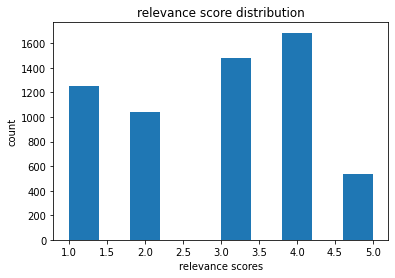

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(annotation['rank'])

plt.title('relevance score distribution')
plt.xlabel('relevance scores')
plt.ylabel('count')

Task 3.1: First try on learn to rank algorithm

In [12]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

ltr_feats1 = pt.BatchRetrieve(index) >> (
    bm25
    **
    tfidf
    **
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [76]:
pt.Experiment(
    [tfidf, pl2, coordinate, bm25],
    test_topics,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt", "num_rel_ret"])

,name,map,ndcg,ndcg_cut_10,num_rel_ret,mrt
0,BR(TF_IDF),0.780551,0.877318,0.696487,3000.0,22.332284
1,BR(PL2),0.746804,0.879473,0.708953,3000.0,25.276841
2,BR(CoordinateMatch),0.520123,0.789584,0.560093,2950.0,21.846610
3,BR(BM25),0.679230,0.794925,0.647895,2728.0,22.849564


In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)
qrels = relevance.copy()
%time rf_pipe.fit(train_topics, qrels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s


CPU times: user 17.9 s, sys: 376 ms, total: 18.3 s
Wall time: 14.8 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.1s finished


In [14]:
import fastrank
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, qrels)

CPU times: user 16.9 s, sys: 183 ms, total: 17.1 s
Wall time: 13.5 s


In [15]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[20]})

%time lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argu

In [17]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, bm25, random],
    test_topics,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"],
    baseline = 3,
    names = ["fastrank","random forest","LambdaMart", "bm25", 'random'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.2s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' a

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


,name,map,ndcg,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,fastrank,0.757483,0.877248,0.716688,20.0,9.0,0.004834,18.0,11.0,0.012514,15.0,7.0,0.027914
1,random forest,0.612634,0.813864,0.577559,11.0,19.0,0.239225,11.0,19.0,0.616351,8.0,17.0,0.199593
2,LambdaMart,0.639680,0.832620,0.657538,13.0,17.0,0.433248,12.0,18.0,0.289042,12.0,13.0,0.784914
3,bm25,0.679230,0.794925,0.647895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,random,0.520123,0.789584,0.560093,9.0,21.0,0.010047,9.0,21.0,0.889580,9.0,18.0,0.120093


Task 3.2: Add more features and test the performance

In [18]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

ltr_feats2 = pt.BatchRetrieve(index) >> (
    tfidf
    **
    pl2
    **
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats2 >> pt.ltr.apply_learned_model(rf)
qrels = relevance.copy()
%time rf_pipe.fit(train_topics, qrels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s


CPU times: user 16 s, sys: 203 ms, total: 16.2 s
Wall time: 14.3 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.1s finished


In [19]:
import fastrank
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats2 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, qrels)

CPU times: user 16.3 s, sys: 158 ms, total: 16.4 s
Wall time: 13.3 s


In [20]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats2 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[20]})

%time lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argu

In [24]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, bm25,random],
    test_topics,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"],
    baseline = 3,
    names = ["fastrank","random forest","LambdaMart", "bm25", 'random'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.2s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' a

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


,name,map,ndcg,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,fastrank,0.759344,0.876502,0.707073,21.0,7.0,0.002773,20.0,10.0,0.011441,17.0,6.0,0.038486
1,random forest,0.613418,0.829489,0.625749,13.0,17.0,0.222366,15.0,15.0,0.355361,13.0,14.0,0.710850
2,LambdaMart,0.569892,0.791564,0.533028,10.0,20.0,0.048780,8.0,22.0,0.926204,8.0,19.0,0.068488
3,bm25,0.679230,0.794925,0.647895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,random,0.520123,0.789584,0.560093,9.0,21.0,0.010047,9.0,21.0,0.889580,9.0,18.0,0.120093


Task 3.3: Add cross encoder as features

In [25]:
annotation1 = pd.read_csv('qidDocPair.csv').drop(['Unnamed: 0'], axis = 1)

Task 3.3.1 create the cos-sim 

In [ ]:
#Run on Great Lakes
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np
similarity = []

for i in range(60):
    qry = annotation1.iloc[(3937*(i+1)-1),3]
    cor = annotation1.iloc[0:3937,1]
    arrs = cor.values
    
    model = CrossEncoder('cross-encoder/stsb-distilroberta-base')
    query = qry
    corpus = arrs
    sentence_combinations = [[query, corpus_sentence] for corpus_sentence in corpus]
    similarity_scores = model.predict(sentence_combinations)
    
    for i in range(3937):
        similarity.append(similarity_scores[i])

In [ ]:
annotation1['similarity'] = similarity
annotation1.to_csv("qidDocPair_result.csv")

Task 3.3.2 add the cos-sim into features

In [26]:
relevance_test = pd.read_csv('qidDocPair_result.csv').drop(['Unnamed: 0'], axis = 1)
relevance_test = relevance_test[['qid','docno','similarity']]
relevance_test['qid'] = relevance_test['qid'].astype(str)
relevance_test['docno'] = relevance_test['docno'].astype(str)

dict3 = {}
for i in relevance_test.index.values:
    qid = relevance_test.loc[i,'qid']
    docno = relevance_test.loc[i,'docno']
    dict3[tuple([qid,docno])] = relevance_test.loc[i,'similarity']

In [55]:

bienc_ltr_feats = pt.BatchRetrieve(index) >> (
    tfidf
    **
    pl2
    **
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
    **
    pt.apply.doc_score(lambda row: dict3[tuple([row.qid, row.docno])])
    
) 


In [28]:
rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, relevance)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    4.6s finished


In [29]:
train_request = fastrank.TrainRequest.coordinate_ascent()
params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567
ca_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(train_request, form='fastrank')
ca_pipe.fit(train_topics, relevance)

In [56]:
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_x_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe.fit(train_topics, relevance, valid_topics, relevance)


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [31]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, bm25, random],
    test_topics,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"],
    baseline = 3,
    names = ["fastrank","random forest","LambdaMart", "bm25", "random"]
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.3s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' a

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


,name,map,ndcg,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,fastrank,0.760175,0.874831,0.702702,21.0,8.0,0.002130,20.0,10.0,0.011883,16.0,6.0,0.041171
1,random forest,0.618919,0.831680,0.625635,13.0,17.0,0.239305,14.0,16.0,0.308027,15.0,12.0,0.685354
2,LambdaMart,0.575566,0.798740,0.570857,9.0,21.0,0.072788,10.0,20.0,0.912978,12.0,16.0,0.205732
3,bm25,0.679230,0.794925,0.647895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,random,0.520123,0.789584,0.560093,9.0,21.0,0.010047,9.0,21.0,0.889580,9.0,18.0,0.120093


Task 3.4 add more features: xgbooster

In [32]:
import xgboost as xgb
params = {'objective': 'rank:ndcg', 
          'learning_rate': 0.2, 
          'gamma': 0.8, 'min_child_weight': 0.01,
          'max_depth': 20,
          'random_state': 42
         }
xgb_1 = xgb.sklearn.XGBRanker(**params)

BaseLTR_LM_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(xgb_1, form="ltr")
BaseLTR_LM_pipe.fit(train_topics, relevance, valid_topics, relevance)

In [33]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, BaseLTR_LM_pipe, bm25, random],
    test_topics,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"],
    baseline = 4,
    names = ["fastrank","random forest","LambdaMart", "XGbooster", "bm25", "random"]
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.3s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' a

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


,name,map,ndcg,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,fastrank,0.760175,0.874831,0.702702,21.0,8.0,0.002130,20.0,10.0,0.011883,16.0,6.0,0.041171
1,random forest,0.618919,0.831680,0.625635,13.0,17.0,0.239305,14.0,16.0,0.308027,15.0,12.0,0.685354
2,LambdaMart,0.575566,0.798740,0.570857,9.0,21.0,0.072788,10.0,20.0,0.912978,12.0,16.0,0.205732
3,XGbooster,0.674534,0.832445,0.609715,14.0,16.0,0.899465,13.0,17.0,0.224151,9.0,15.0,0.286790
4,bm25,0.679230,0.794925,0.647895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,random,0.520123,0.789584,0.560093,9.0,21.0,0.010047,9.0,21.0,0.889580,9.0,18.0,0.120093


Task 3.5 fine tune

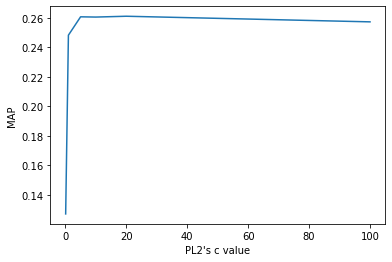

In [41]:
pl2 = pt.BatchRetrieve(index, wmodel="PL2", controls={'c' : 1})
rtr = pt.GridScan(
    pl2,
    {pl2 : {'c' : [0.1, 1, 5, 10, 20, 100]}},
    train_topics,
    relevance,
    ["map"]
)
import matplotlib.pyplot as plt

plt.plot(rtr["tran_0_c"], rtr["map"])
plt.xlabel("PL2's c value")
plt.ylabel("MAP")
plt.show()

In [36]:
BM25 = pt.BatchRetrieve(index, wmodel="BM25", controls={"bm25.b" : 0.75, "bm25.k_1": 0.75, "bm25.k_3": 0.75})
BM25Tune = pt.GridSearch(
    BM25,
    {BM25: {"bm25.b"  : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1 ],
            "bm25.k_1": [0.3, 0.6, 0.9, 1.2, 1.4, 1.6, 2],
            "bm25.k_3": [0.5, 2, 4, 6, 8, 10, 12, 14, 20]
    }},
    train_topics,
    relevance,
    "map")

Best map is 0.343998
Best setting is ['BR(BM25) bm25.b=0.4', 'BR(BM25) bm25.k_1=2', 'BR(BM25) bm25.k_3=0.5']


In [ ]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, BaseLTR_LM_pipe, rtr, bm25, random],
    test_topics,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"],
    baseline = 5,
    names = ["fastrank","random forest","LambdaMart", "XGbooster", 'pl2Tune',"bm25", "random"]
)

Task 3.5.1 fine tune manually

In [57]:
import xgboost as xgb
params = {'objective': 'rank:ndcg', 
          'learning_rate': 0.2, 
          'gamma': 0.8, 'min_child_weight': 0.01,
          'max_depth': 20,
          'n_estimators': 200,
          'random_state': 42
         }
xgb_1 = xgb.sklearn.XGBRanker(**params)

BaseLTR_LM_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(xgb_1, form="ltr")
BaseLTR_LM_pipe.fit(train_topics, relevance, valid_topics, relevance)

In [58]:
rf = RandomForestRegressor(n_estimators=800, verbose=1, random_state=SEED, n_jobs=2, max_features=3)
rf_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, relevance)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    6.5s finished


In [59]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, BaseLTR_LM_pipe, bm25, random],
    test_topics,
    relevance,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"],
    baseline = 4,
    names = ["fastrank","random forest","LambdaMart", "XGbooster", "bm25","random"]
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.5s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/p

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


,name,map,ndcg,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,fastrank,0.743121,0.881126,0.725310,16.0,14.0,0.079337,15.0,15.0,0.017476,15.0,8.0,0.032863
1,random forest,0.640503,0.839123,0.656864,13.0,17.0,0.443354,13.0,17.0,0.226888,14.0,11.0,0.827763
2,LambdaMart,0.603491,0.812986,0.577073,12.0,18.0,0.173733,8.0,22.0,0.618604,10.0,16.0,0.198268
3,XGbooster,0.643973,0.818376,0.582591,15.0,15.0,0.377530,12.0,18.0,0.473640,8.0,17.0,0.142338
4,bm25,0.679230,0.794925,0.647895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,random,0.520123,0.789584,0.560093,9.0,21.0,0.010047,9.0,21.0,0.889580,9.0,18.0,0.120093


Task 3.6: Add cosine-similarity of bi encoder as features

In [47]:
annotation1 = pd.read_csv('qidDocPair.csv').drop(['Unnamed: 0'], axis = 1)

Task 3.6.1: process of embedding, no need to run

In [ ]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')
sim_list = []

cor = annotation1.iloc[0:3937,1]
arrs = cor.values
corpus = arrs
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

for i in range(60):
    query = annotation1.iloc[(3937*(i+1)-1),3]

    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    for j in range(3937):
        sim_list.append(float(cos_scores[j]))

In [ ]:
annotation1['similarity'] = sim_list
annotation1.to_csv("annotation1.csv")

Task 3.6.2: add the similarity to features and replace the previous cos-sim score

In [48]:
relevance_test = pd.read_csv('annotation1.csv').drop(['Unnamed: 0'], axis = 1)
relevance_test = relevance_test[['qid','docno','similarity']]
relevance_test['qid'] = relevance_test['qid'].astype(str)
relevance_test['docno'] = relevance_test['docno'].astype(str)

In [60]:
coordinate = pt.BatchRetrieve(index, wmodel = 'CoordinateMatch')
qid = list(relevance_test['qid'])
docno = list(relevance_test['docno'])
dict_key = zip(qid,docno)
dict_key
sim_dict = dict(zip(dict_key,relevance_test['similarity']))
bienc_ltr_feats_1 = pt.BatchRetrieve(index) >>(
    tfidf
    **
    pl2
    **
    coordinate
    **
    pt.apply.doc_score(lambda x:sim_dict[tuple([x.qid,x.docno])])
)

In [61]:
rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe = bienc_ltr_feats_1 >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, relevance)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    4.1s finished


In [62]:
train_request = fastrank.TrainRequest.coordinate_ascent()
params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567
ca_pipe = bienc_ltr_feats_1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
ca_pipe.fit(train_topics, relevance)

In [63]:
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_x_pipe = bienc_ltr_feats_1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe.fit(train_topics, relevance, valid_topics, relevance)



[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argu

In [64]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, bm25, random],
    test_topics,
    relevance,
    baseline = 3,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"],
    names = ["fastrank","random forest","LambdaMart", "bm25", "random"]
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.2s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' a

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


,name,map,ndcg,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,fastrank,0.743121,0.881126,0.725310,16.0,14.0,0.079337,15.0,15.0,0.017476,15.0,8.0,0.032863
1,random forest,0.621176,0.831134,0.638976,13.0,17.0,0.262489,13.0,17.0,0.315736,15.0,11.0,0.819975
2,LambdaMart,0.585242,0.801764,0.574654,12.0,18.0,0.123269,11.0,19.0,0.851467,12.0,14.0,0.176155
3,bm25,0.679230,0.794925,0.647895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,random,0.520123,0.789584,0.560093,9.0,21.0,0.010047,9.0,21.0,0.889580,9.0,18.0,0.120093


Task 3.6.3: Add both cross encoder sim and the biencoder sim 

In [439]:
bienc_ltr_feats_2 = pt.BatchRetrieve(index) >>(
    tfidf
    **
    pl2
    **
    coordinate
    **
    pt.apply.doc_score(lambda x:sim_dict[tuple([x.qid,x.docno])])
    **
    pt.apply.doc_score(lambda row: dict3[tuple([row.qid, row.docno])])
)

In [440]:
rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe = bienc_ltr_feats_2 >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, relevance)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    6.8s finished


In [441]:
train_request = fastrank.TrainRequest.coordinate_ascent()
params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567
ca_pipe = bienc_ltr_feats_2 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
ca_pipe.fit(train_topics, relevance)

In [442]:
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_x_pipe = bienc_ltr_feats_2 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe.fit(train_topics, relevance, valid_topics, relevance)



[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argu

In [65]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, bm25, random],
    test_topics,
    relevance,
    baseline = 4,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"],
    names = ["fastrank","random forest","LambdaMart", "bm25", "random"])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.3s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' a

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


,name,map,ndcg,ndcg_cut_10,mrt,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,fastrank,0.743121,0.881126,0.725310,877.663768,23.0,7.0,0.000002,26.0,4.0,0.000003,20.0,7.0,0.000840
1,random forest,0.621176,0.831134,0.638976,899.541438,24.0,6.0,0.018936,21.0,9.0,0.011798,18.0,11.0,0.058838
2,LambdaMart,0.585242,0.801764,0.574654,848.273933,20.0,10.0,0.127707,19.0,11.0,0.491370,17.0,11.0,0.794708
3,bm25,0.679230,0.794925,0.647895,24.957781,21.0,9.0,0.010047,21.0,9.0,0.889580,18.0,9.0,0.120093
4,random,0.520123,0.789584,0.560093,742.802904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Task 4: final pick (cross_encoder, fastrank)

In [66]:
bienc_ltr_feats_1 = pt.BatchRetrieve(index) >>(
    tfidf
    **
    pl2
    **
    coordinate
    **
    pt.apply.doc_score(lambda x:sim_dict[tuple([x.qid,x.docno])])
)

In [67]:
train_request = fastrank.TrainRequest.coordinate_ascent()
params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567
ca_pipe = bienc_ltr_feats_1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
ca_pipe.fit(train_topics, relevance)

Task 4.1: simple search engine

In [376]:
# for each in test_topics['query'].values: 
#     BaseLTR_LM_pipe.search(each)

In [69]:
top5Search = ca_pipe.search(test_topics['query'].values[1]).head(5)
qidDoc = top5Search[['qid', 'docno']].to_dict()

In [71]:
query = str(input())
resultcsv = pd.DataFrame()
annotationIndex['docno'] = annotationIndex['docno'].astype(str)
top5doc = ca_pipe.search(query)[0:5]
val = top5doc.docno.values
print("\nPolicy Recommend for " + query + "\n")
for x in val:
    temp = annotationIndex[annotationIndex['docno'] == x]
    
    for j in temp['text']:
        j = j.replace('.', " ")
        print(j)

Infant Japan

Policy Recommend for Infant Japan

Japan National infant feeding recommendation for HIV exposed infants Yes, replacement feeding [WHO Policy Data 2021]
Japan Different regimens recommended for high risk infants Yes [WHO Policy Data 2021]
Japan Policy recommendation on point of care early infant diagnosis testing No [WHO Policy Data 2021]
Japan Recommended duration of PMTCT regimen for HIV exposed infants Four weeks [WHO Policy Data 2021]
Japan Recommended regimens for high risk infants AZT, 3TC, NVP [WHO Policy Data 2021]
